## Notebook by: Syaiful Andy

# <font color='blue'>Task</font>

Task
A simple yet powerful marketing technique is an analysis utilizing recency (how recent was the customer's last purchase), frequency (how often did the customer make a purchase in a given period) and monetary (how much money did the customer spend in a given period) data to identify the best customers and perform targeted marketing campaigns.

As data scientist you are asked to segment the customers using transaction data and profile them based-on their characteristics (recency, frequency, monetary). After you find the segments, name them using understandable words so marketing team can easily create campaign strategies.

Data: ../data/transactions.csv

Hints: For each customer id, generate time difference between their last transaction and today. You should also calculate number of transaction and total amount of spending. You are allowed to use SQL.

Output: Push the executed notebook into your github repo and submit the URL to ketua kelas no later than August 21, 2021. Note that notebook must contain explanatory analysis and clustering as well as story about your findings.

Goodluck!



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
warnings.filterwarnings("ignore")
import os

## Load Data & Data Cleansing

In [2]:
transaction_df = pd.read_csv(r'data/transactions.csv')
transaction_df.head()

customer_id trans_date  trans_amount
0      CS5295  11-Feb-18            35
1      CS4768  15-Mar-20            39
2      CS2122  26-Feb-18            52
3      CS1217  16-Nov-16            99
4      CS1850  20-Nov-18            78

In [3]:
#Check column data types
transaction_df.dtypes

customer_id     object
trans_date      object
trans_amount     int64
dtype: object

In [4]:
#We want to change trans_date type to datetime format
pd.to_datetime(transaction_df['trans_date'])

ParserError: day is out of range for month: 29-Feb-17

In [6]:
transaction_df[transaction_df['trans_date']=='28-Feb-17'].count()

customer_id     82
trans_date      82
trans_amount    82
dtype: int64

In [7]:
transaction_df[transaction_df['trans_date']=='29-Feb-17'].count()

customer_id     90
trans_date      90
trans_amount    90
dtype: int64

In [8]:
transaction_df[transaction_df['trans_date']=='01-Mar-17'].count()

customer_id     91
trans_date      91
trans_amount    91
dtype: int64

In [9]:
transaction_df.groupby('trans_date').count().min()

customer_id     55
trans_amount    55
dtype: int64

In [10]:
transaction_df.groupby('trans_date').count().max()

customer_id     141
trans_amount    141
dtype: int64

From the output we can see we have invalid data (29-Feb-17) in trans_date column, so we will drop the row that contain trans_date 29-Feb-17. 
We choose to drop the data because we can see maximum number of row for each date is 141 and minimum row is 55, so if we assign 29-Feb-17 to 01-Mar-17 or 28-Feb-17, it will change the pattern in our data.

In [11]:
# Data Cleansing
transaction_df_2 = transaction_df.drop(transaction_df[transaction_df['trans_date']=='29-Feb-17'].index)

In [12]:
transaction_df_2

customer_id trans_date  trans_amount
0           CS5295  11-Feb-18            35
1           CS4768  15-Mar-20            39
2           CS2122  26-Feb-18            52
3           CS1217  16-Nov-16            99
4           CS1850  20-Nov-18            78
...            ...        ...           ...
124995      CS8433  26-Jun-16            64
124996      CS7232  19-Aug-19            38
124997      CS8731  28-Nov-19            42
124998      CS8133  14-Dec-18            13
124999      CS7996  13-Dec-19            36

[124910 rows x 3 columns]

In [13]:
#We want to change trans_date type to datetime format
transaction_df_2['trans_date']=pd.to_datetime(transaction_df_2['trans_date'])

In [14]:
#Check column data types
transaction_df_2.dtypes

customer_id             object
trans_date      datetime64[ns]
trans_amount             int64
dtype: object

In [15]:
transaction_df_2

customer_id trans_date  trans_amount
0           CS5295 2018-02-11            35
1           CS4768 2020-03-15            39
2           CS2122 2018-02-26            52
3           CS1217 2016-11-16            99
4           CS1850 2018-11-20            78
...            ...        ...           ...
124995      CS8433 2016-06-26            64
124996      CS7232 2019-08-19            38
124997      CS8731 2019-11-28            42
124998      CS8133 2018-12-14            13
124999      CS7996 2019-12-13            36

[124910 rows x 3 columns]

In [16]:
#Check Duplicate data
transaction_df_2.duplicated().sum()

6

In [17]:
#Drop duplicate data
transaction_df_2=transaction_df_2.drop_duplicates()

In [18]:
#Check Duplicate data
transaction_df_2.duplicated().sum()

0

In [19]:
#Check Null Value
transaction_df_2.isnull().values.any()

False

## Recency (how recent was the customer's last purchase)

In [20]:
today = pd.Timestamp.today()

In [21]:
Days_diff = (today - transaction_df_2['trans_date']).dt.days

In [22]:
transaction_df_2['Recency']=Days_diff

In [23]:
recency = transaction_df_2.groupby('customer_id').min('Recency')

In [24]:
recency.drop(columns='trans_amount',axis=1,inplace=True)

In [25]:
recency

Recency
customer_id         
CS1112           577
CS1113           551
CS1114           548
CS1115           526
CS1116           719
...              ...
CS8996           613
CS8997           777
CS8998           600
CS8999           773
CS9000           532

[6889 rows x 1 columns]

## Frequency (how often did the customer make a purchase in a given period) 

In [26]:
frequency=transaction_df_2.groupby('customer_id').count()

In [27]:
frequency['frequency']=transaction_df_2.groupby('customer_id').count()['trans_date']

In [28]:
frequency = frequency[['frequency']]

In [29]:
frequency

frequency
customer_id           
CS1112              15
CS1113              20
CS1114              19
CS1115              22
CS1116              13
...                ...
CS8996              13
CS8997              14
CS8998              13
CS8999              12
CS9000              13

[6889 rows x 1 columns]

## Monetary (how much money did the customer spend in a given period)

In [30]:
monetary = transaction_df_2.groupby('customer_id').sum('trans_amount')

In [31]:
monetary.drop(columns='Recency',axis=1,inplace=True)

In [32]:
monetary

trans_amount
customer_id              
CS1112               1012
CS1113               1490
CS1114               1432
CS1115               1659
CS1116                857
...                   ...
CS8996                582
CS8997                543
CS8998                624
CS8999                383
CS9000                533

[6889 rows x 1 columns]

## Join 3 Features (Recency, Frequency, Monetary)

In [33]:
#Join recency and frequency
data = recency.join(frequency) 

In [34]:
#Join data and monetary
data = data.join(monetary) 

In [35]:
data

Recency  frequency  trans_amount
customer_id                                  
CS1112           577         15          1012
CS1113           551         20          1490
CS1114           548         19          1432
CS1115           526         22          1659
CS1116           719         13           857
...              ...        ...           ...
CS8996           613         13           582
CS8997           777         14           543
CS8998           600         13           624
CS8999           773         12           383
CS9000           532         13           533

[6889 rows x 3 columns]

## Data Exploration

In [36]:
data.shape

(6889, 3)

In [37]:
data.describe()

Recency    frequency  trans_amount
count  6889.000000  6889.000000   6889.000000
mean    596.349252    18.130933   1178.359123
std      85.545443     5.192154    465.606743
min     515.000000     4.000000    149.000000
25%     538.000000    14.000000    781.000000
50%     569.000000    18.000000   1227.000000
75%     627.000000    22.000000   1520.000000
max    1373.000000    39.000000   2933.000000

## Data Visualization

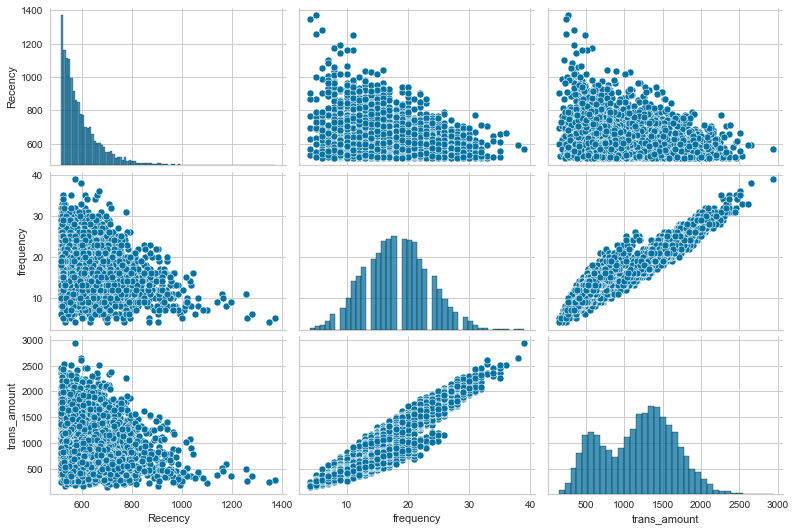

In [38]:
# Check inter varibale correlation
sns.pairplot(data, aspect=1.5)
plt.show()

From the plot we can see linear correlation of frequency and trans_amount variable

## Standardized Variable

In [39]:
standardize = StandardScaler()
data_std = pd.DataFrame(standardize.fit_transform(data))

In [40]:
data_std.columns = data.columns

In [41]:
data_std

Recency  frequency  trans_amount
0    -0.226203  -0.603056     -0.357321
1    -0.530157   0.360005      0.669371
2    -0.565229   0.167393      0.544793
3    -0.822421   0.745230      1.032364
4     1.433854  -0.988281     -0.690244
...        ...        ...           ...
6884  0.194656  -0.988281     -1.280914
6885  2.111905  -0.795668     -1.364682
6886  0.042679  -0.988281     -1.190703
6887  2.065143  -1.180893     -1.708345
6888 -0.752278  -0.988281     -1.386161

[6889 rows x 3 columns]

# K-Means: with 2 variables with speculated k

First, we will try to segment the data based on 2 variables: Recency and frequency

In [42]:
data_is = data_std[['Recency' , 'frequency']].values

In [43]:
data_is

array([[-0.22620325, -0.60305619],
       [-0.53015733,  0.36000517],
       [-0.56522896,  0.1673929 ],
       ...,
       [ 0.04267922, -0.98828073],
       [ 2.06514296, -1.180893  ],
       [-0.75227763, -0.98828073]])

In [44]:
k = 3
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(data_is)

centroids = k_means.cluster_centers_
centroids

array([[-0.28626929, -0.69791183],
       [-0.3431659 ,  0.88239681],
       [ 1.9265558 , -0.73311912]])

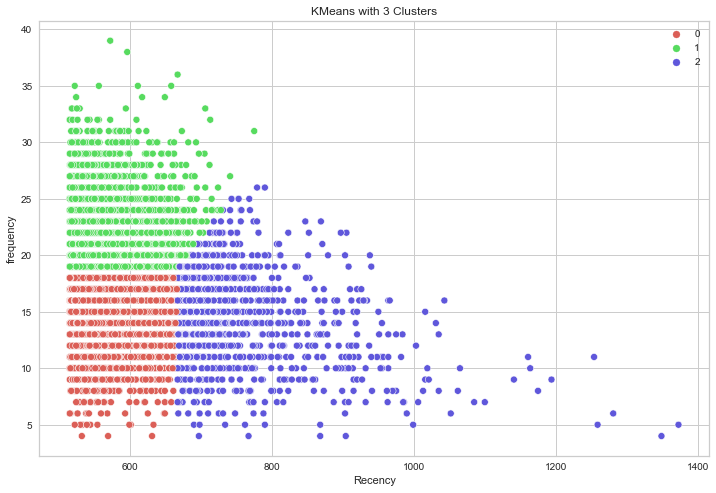

In [45]:
Segment = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(data['Recency'], data['frequency'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

`k_means.cluster_centers_` outputs the centroid based on standardized-data. We can easily calculate the centroid using original data

In [46]:
centroids = data[['Recency','frequency']].groupby(Segment, as_index=False).mean()
centroids

Recency  frequency
0  571.861996  14.507531
1  566.995104  22.712141
2  761.145361  14.324742

### Conclusion for 3 cluster K-Means with 2 Variable:
1. Green color in image: Seems like loyal customer, have recent purchase and have high purchase frequency
2. Red color in image: Seems like Low/Medium loyal customer, have recent purchase but low/medium purchase frequency
3. Blue color in image: Seems like Low/Not loyal customer, because have not purchase for medium/long time and have low/medium purchase frequency

# K-Means (2): 2 Variables with Elbow Method and Silhouette to Determine k

In [47]:
def k_means_inertia_silhouette(data, k_max = 9, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(data)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(data, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

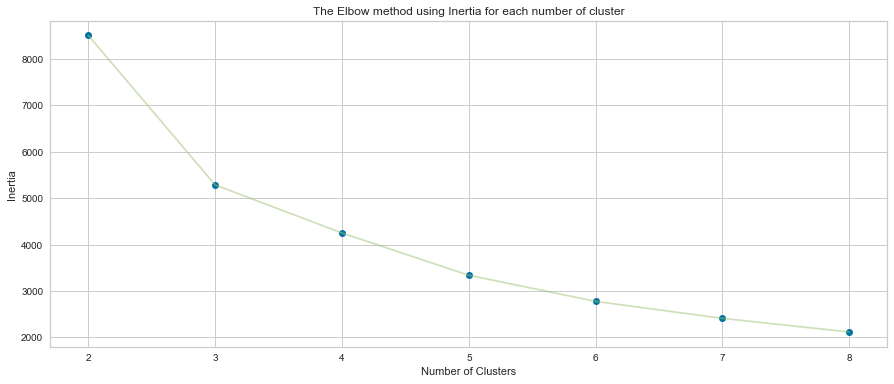

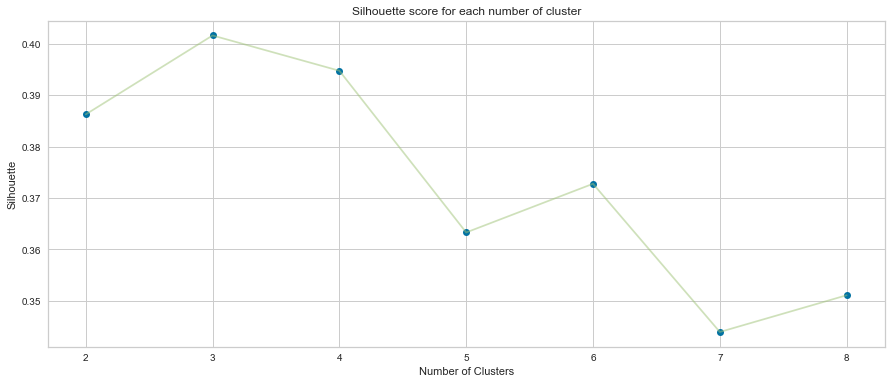

In [48]:
inertia, silhouette = k_means_inertia_silhouette(data = data_is)

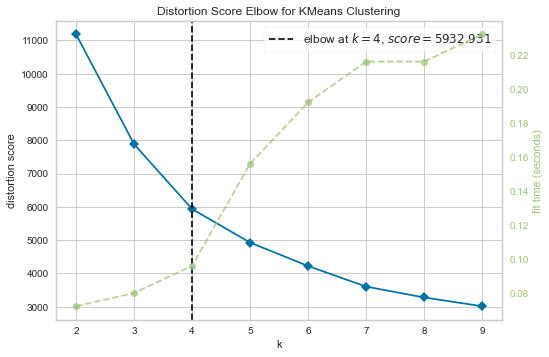

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [49]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(k_means, k=(2,10))

visualizer.fit(data_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### From elbow method the best k is 4 but form silhouette method the best k is 3 cluster. We can choose to use K = 4 to make clustering more specific

In [50]:
k = 4
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(data_is)

centroids = k_means.cluster_centers_
centroids

array([[-0.41825981,  0.91510632],
       [ 0.94502634, -0.37751625],
       [ 3.13182193, -1.1681332 ],
       [-0.43757019, -0.72787216]])

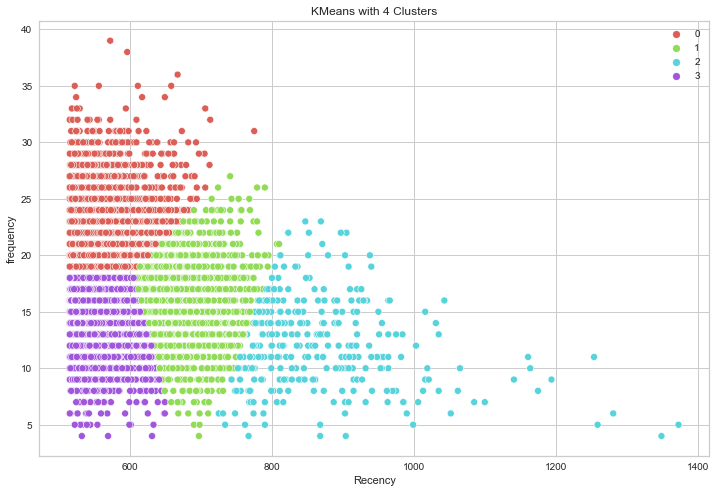

In [51]:
Segment = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(data['Recency'], data['frequency'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

In [52]:
centroids = data[['Recency','frequency']].groupby(Segment, as_index=False).mean()
centroids

Recency  frequency
0  560.571629  22.881961
1  677.238095  16.166289
2  864.617089  12.072785
3  558.919833  14.351983

### Conclusion for 4 cluster K-Means with 2 Variable:
1. Red color in image: Seems like loyal customer, have recent purchase and have high purchase frequency
2. Green color in image: Seems like Low/Medium loyal customer, have recent purchase but low/medium purchase frequency
3. Purple color in image: Seems like Low Loyal / New Customer because have recently purchase but have low/medium purchase frequency
4. Blue color in image: Seems like Not loyal customer, because have not purchase for long time and have low/medium purchase frequency

# K-Means (3): 3 Variables with Elbow Method and Silhouette to Determine k

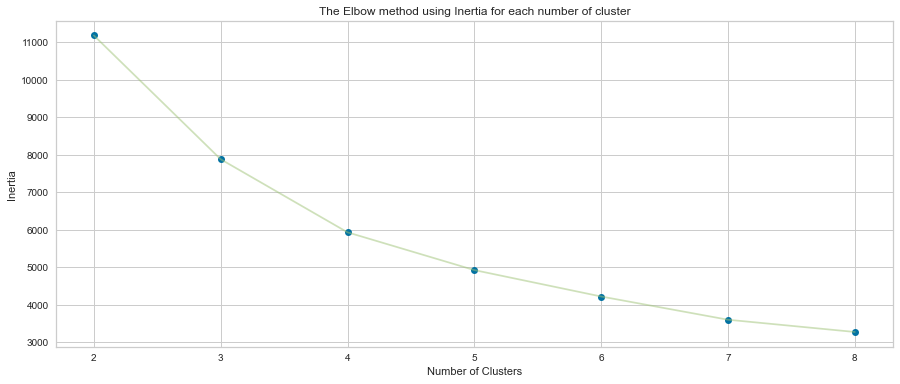

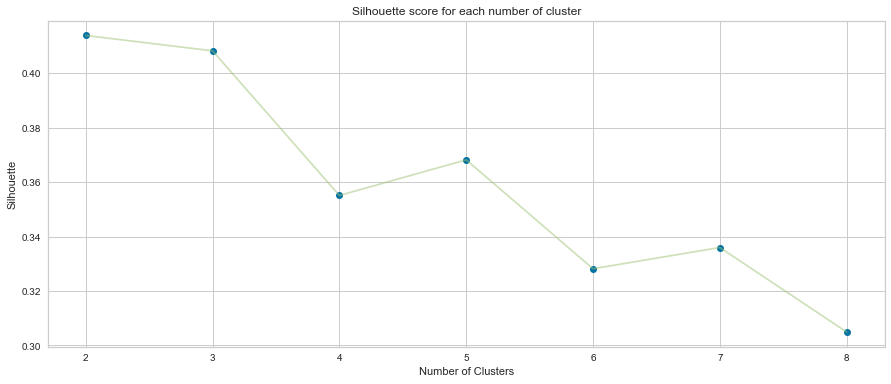

In [53]:
inertia, silhouette = k_means_inertia_silhouette(data_std)

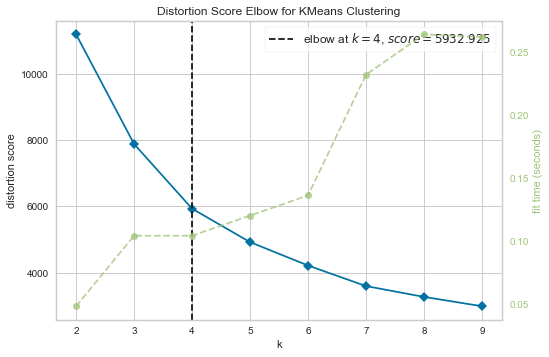

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(data_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### From elbow method the best k is 4 but form silhouette method the best k is 2 cluster. We will choose to use K = 4 to make clustering more specific

In [55]:
k = 4
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(data_std)

KMeans(n_clusters=4, random_state=123)

In [56]:
Segment = k_means.labels_
data_std.groupby(Segment, as_index=False).mean()

Recency  frequency  trans_amount
0 -0.191317  -1.038916     -1.148154
1 -0.351725   1.270868      1.222335
2  2.331673  -0.951922     -0.915636
3 -0.198772   0.085647      0.178141

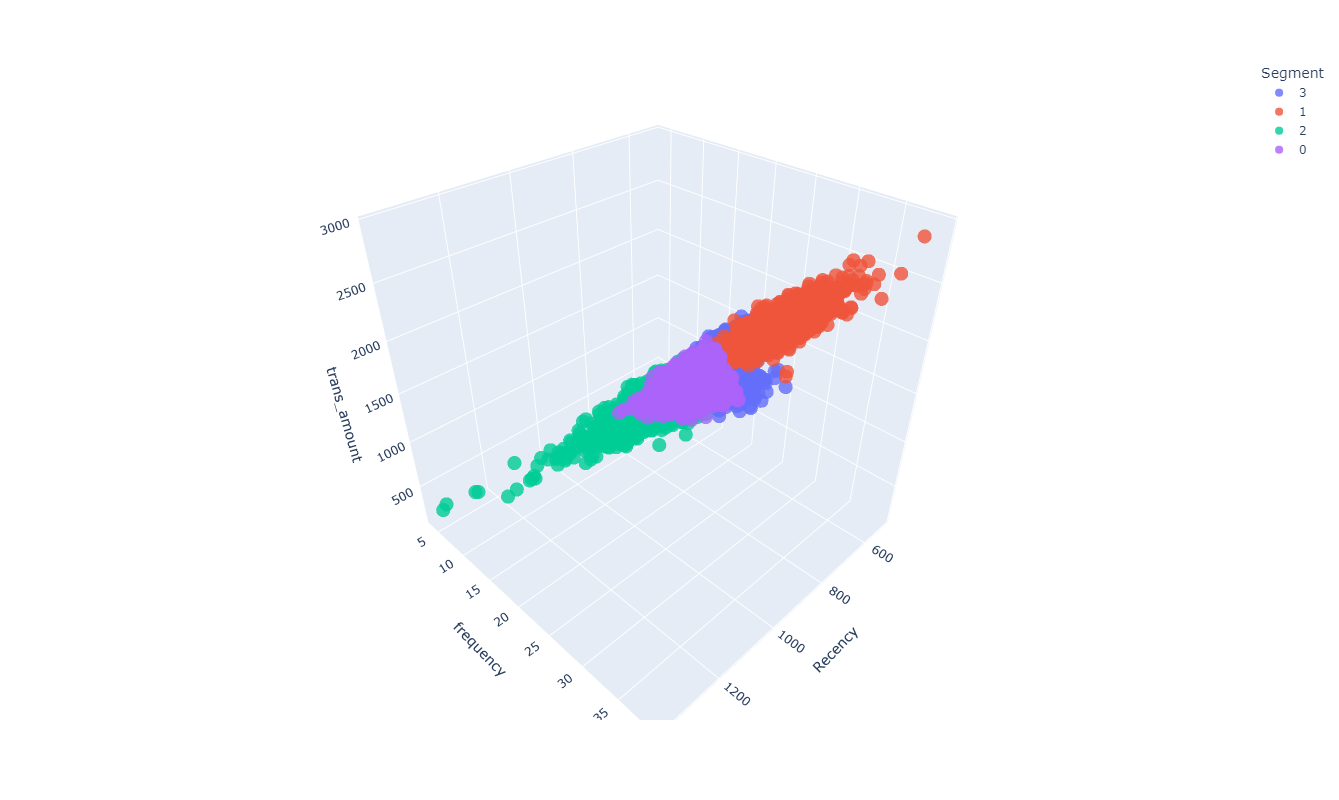

In [57]:
data['Segment'] = list(map(str, Segment))
fig = px.scatter_3d(data, x='Recency', y='frequency', z='trans_amount', color='Segment',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 

In [58]:
data_std_2 = data_std.copy()

In [59]:
data_std_2['cluster']= k_means.labels_

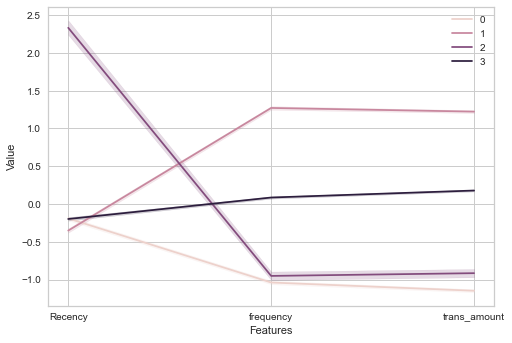

In [60]:
melted_RFM=pd.melt(data_std_2.reset_index(),
                  id_vars=['cluster'],
                   value_vars=['Recency','frequency','trans_amount'],
                   var_name='Features',
                   value_name='Value'
                  )

sns.lineplot('Features','Value',hue='cluster',data=melted_RFM)
plt.legend()

### Conclusion for 4 cluster K-Means with 3 Variable:
1. Label 1 or red dot in 3d plot : Seems like very loyal customer, have recent purchase, have high purchase frequency, and high transaction amount
2. Label 3 or blue dot in 3d plot: Seems like Medium loyal customer, have recent purchase, medium purchase frequency, and medium transaction amount
3. Label 0 or purple dot in 3d plot: Seems like New Customer, have recent purchase but have low purchase frequency, and low transaction amount
4. Label 2 or green dot in 3d plot: Seems like Not loyal customer, because have not purchase for long time, have low purchase frequency and low transaction amount

### Hierarchical Clustering  : Agglomerative

In [61]:
agglo_cluster = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'complete')
Segment = agglo_cluster.fit_predict(data_std)

In [62]:
centroids = data.groupby(Segment, as_index=False).mean()
centroids

Recency  frequency  trans_amount
0   581.030843  18.262321   1191.823688
1   809.322581  12.135945    653.391705
2   580.445161  30.251613   2152.870968
3  1235.100000   7.800000    387.800000

In [63]:
data_std_3 = data_std.copy()

In [64]:
data_std_3['cluster']=Segment

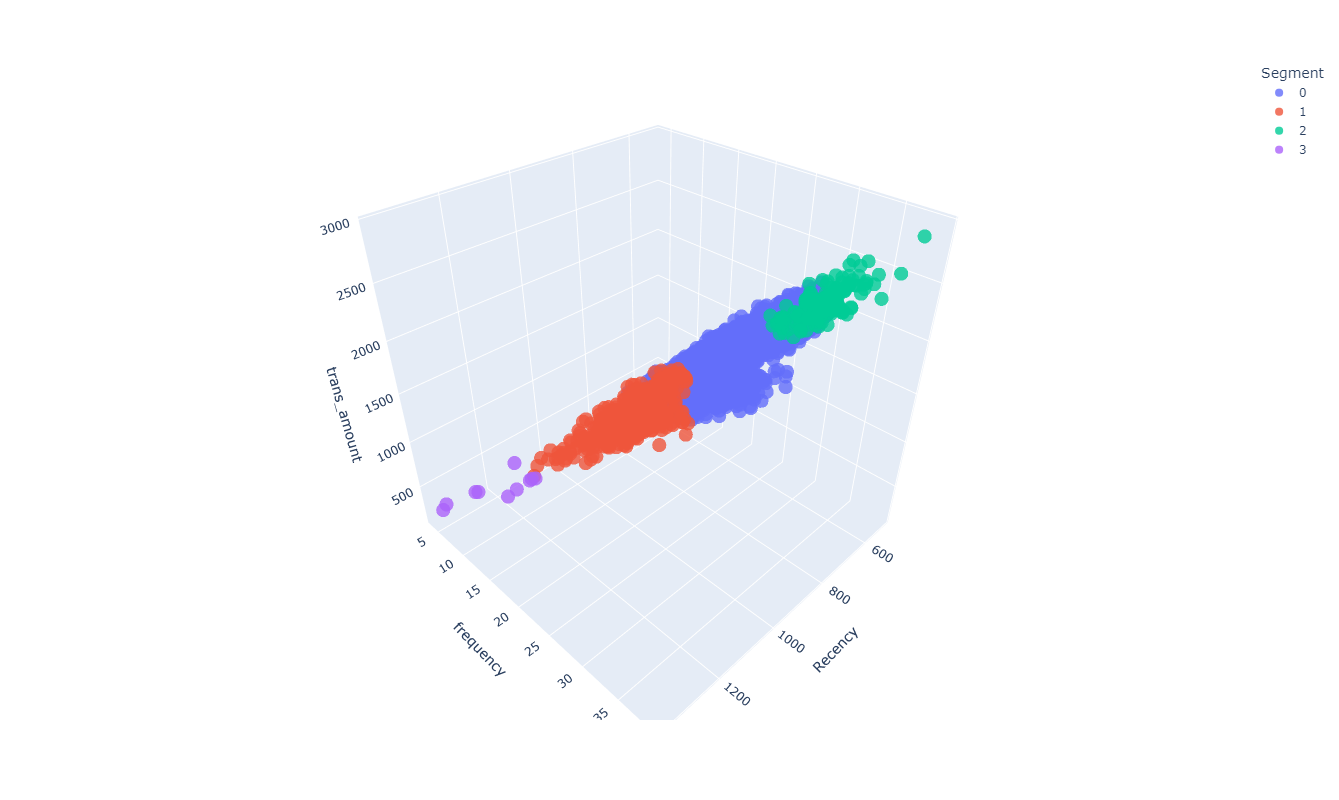

In [65]:
data['Segment'] = list(map(str, Segment))
fig = px.scatter_3d(data, x='Recency', y='frequency', z='trans_amount', color='Segment',
                   opacity = 0.8, height=800)
fig.show()

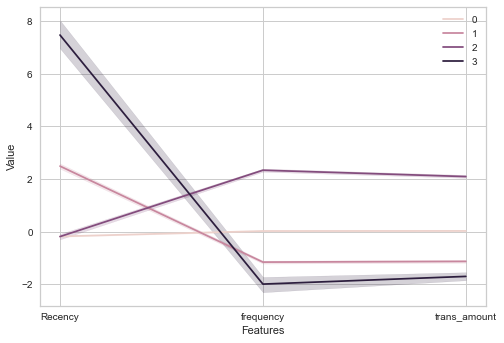

In [66]:
melted_RFM=pd.melt(data_std_3.reset_index(),
                  id_vars=['cluster'],
                   value_vars=['Recency','frequency','trans_amount'],
                   var_name='Features',
                   value_name='Value'
                  )

sns.lineplot('Features','Value',hue='cluster',data=melted_RFM)
plt.legend()

### Conclusion 4 cluster Hierarchical Agglomerative Clustering with 3 Variable:
1. Label 2 or green dot in 3d plot : Seems like very loyal customer, have recent purchase, have high purchase frequency, and high transaction amount
2. Label 0 or blue dot in 3d plot: Seems like Low-Medium loyal customer, have recent purchase, Low/medium purchase frequency, and Low/medium transaction amount
3. Label 1 or red dot in 3d plot: Seems like Low Loyal Customer, have not purchase in medium long time, have low/medium purchase frequency, and low transaction amount
4. Label 3 or purple dot in 3d plot: Seems like Not loyal customer, because have not purchase for long time, have low purchase frequency and low transaction amount

# <font color='blue'>Density-based Clustering: DBSCAN</font>

In [67]:
S=data_std.to_numpy()

In [68]:
S

array([[-0.22620325, -0.60305619, -0.35732128],
       [-0.53015733,  0.36000517,  0.66937067],
       [-0.56522896,  0.1673929 ,  0.54479299],
       ...,
       [ 0.04267922, -0.98828073, -1.19070304],
       [ 2.06514296, -1.180893  , -1.7083448 ],
       [-0.75227763, -0.98828073, -1.38616113]])

In [69]:
# Try to make estimated number of clusters = 4

In [70]:
db = DBSCAN(eps=0.2, min_samples=14).fit(S)

In [71]:
# Number of clusters in labels, ignoring noise if present.
# the label -1 is considered as noise by the DBSCAN algorithm

labels = db.labels_ 
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 1484


In [72]:
Segmentdb = db.labels_ 

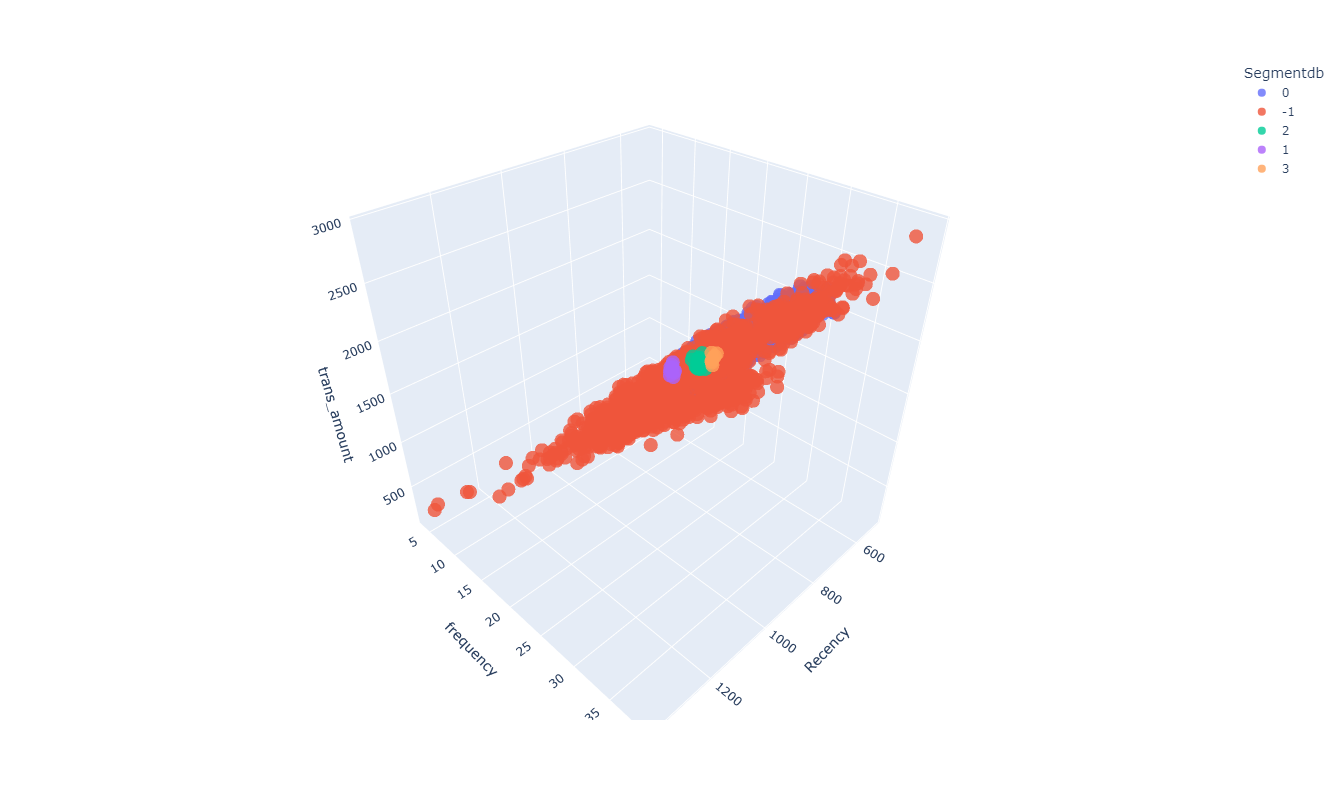

In [73]:
data['Segmentdb'] = list(map(str, Segmentdb))
fig = px.scatter_3d(data, x='Recency', y='frequency', z='trans_amount', color='Segmentdb',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 

### Conlclusion 4 Cluster DBSCAN with 3 Variable:
When we make 4 cluster with DBSCAN, we will get a lot of outlier

## Comparing K-Means, Hierarchical, and DbScan with 4 number of clusters

In [74]:
# Hierarchical
unique, counts = np.unique(Segment, return_counts=True)
dict(zip(unique, counts))

{0: 6290, 1: 434, 2: 155, 3: 10}

In [75]:
# DbScan
unique, counts = np.unique(db.labels_, return_counts=True)
dict(zip(unique, counts))

{-1: 1484, 0: 5370, 1: 10, 2: 17, 3: 8}

In [76]:
# K-means
unique, counts = np.unique(k_means.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 1765, 1: 1738, 2: 641, 3: 2745}

### Conclusion in Comparing K-Means, Hierarchical, and DbScan with 4 number of clusters : 
K-Means seems better than Hierarchical and DBSCAN when using this dataset. 
1. In Hierarchical Clustering one cluster have very big number of customer (6290) and one cluster have very few number of customer (10). 
2. In DBSCAN one cluster have very big number of customer (5370) and very big number of outliers (1484)
3. In K-Means, each cluster have similar number of customer (1765 vs 1738 vs 641 vs 2745)

So we choose to use K-Means for our Customer Segmentation


### Conclusion Clusters for Marketing Team:
1. Cluster A : Very loyal customer, have recent purchase, have high purchase frequency, and high transaction amount
2. Cluster B: Medium loyal customer, have recent purchase, medium purchase frequency, and medium transaction amount
3. Cluster C: Low Loyal / New Customer, have recent purchase but have low purchase frequency, and low transaction amount
4. Cluster D: Not loyal customer, because have not purchase for long time, have low purchase frequency and low transaction amount

In [77]:
data.drop(columns='Segment',axis=1,inplace=True)

In [81]:
data.drop(columns='Segmentdb',axis=1,inplace=True)

In [82]:
# We will assign k-means label to our dataframe
cluster = k_means.labels_
# Change label 1 with loyal, 3 with Medium loyal, 0 with Low Loyal / New Customer, 2 with Not Loyal
cluster = np.where(cluster==1, 'Very loyal', cluster) 
cluster = np.where(cluster=='3', 'Medium loyal', cluster) 
cluster = np.where(cluster=='0', 'Low loyal / New Customer', cluster) 
cluster =  np.where(cluster=='2', 'Not Loyal', cluster) 
data['Customer Segment'] = cluster

In [83]:
data

Recency  frequency  trans_amount          Customer Segment
customer_id                                                            
CS1112           577         15          1012              Medium loyal
CS1113           551         20          1490              Medium loyal
CS1114           548         19          1432              Medium loyal
CS1115           526         22          1659                Very loyal
CS1116           719         13           857                 Not Loyal
...              ...        ...           ...                       ...
CS8996           613         13           582  Low loyal / New Customer
CS8997           777         14           543                 Not Loyal
CS8998           600         13           624  Low loyal / New Customer
CS8999           773         12           383                 Not Loyal
CS9000           532         13           533  Low loyal / New Customer

[6889 rows x 4 columns]

In [84]:
!jupyter nbconvert --to html Clustering_RFM.ipynb

[NbConvertApp] Converting notebook Clustering_RFM.ipynb to html
[NbConvertApp] Writing 5341899 bytes to Clustering_RFM.html
